In [10]:
import os
import math
import time
import glob
import pathlib
from natsort import natsorted
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from IPython import display
from PIL import Image
from functools import reduce
import seaborn as sns
from beatbrain import utils
from beatbrain import display
tf.compat.v1.enable_eager_execution()

In [11]:
def load_images_as_tensor(files):
    files = [file.decode('utf8') for file in files.numpy()]
    images = np.asarray([utils.load_image(file) for file in files])
    images_tensor = tf.convert_to_tensor(images)
    return images_tensor


def load_dataset(data_root, window_size=1, batch_size=1, shuffle=True, prefetch=1):
    directories = list({os.path.dirname(file) for file in data_root.rglob('*.exr')})
    files = [natsorted(map(str, pathlib.Path(d).glob('*.exr'))) for d in directories]
    if not files:
        raise ValueError(f"No data found in {data_root}")
    datasets = [tf.data.Dataset.from_generator(lambda f=f: f, 'string') for f in files]
    datasets = [d.window(window_size, shift=1, drop_remainder=True).flat_map(lambda x: x.batch(window_size)) for d in datasets]
    dataset = reduce(lambda d1, d2: d1.concatenate(d2), datasets)

    if shuffle:
        dataset = dataset.shuffle(50000)
    dataset = dataset.map(lambda files: tf.py_function(load_images_as_tensor, [files], Tout=tf.float32), num_parallel_calls=8)
    dataset = dataset.map(lambda e: tf.transpose(e, perm=[1, 2, 0]))  # Convert CHW to HWC
    if batch_size:
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if prefetch:
        dataset = dataset.prefetch(prefetch)
    return dataset

In [12]:
# Input
DATA_ROOT = "../data/fma/image"
SHUFFLE = True
PREFETCH = 128

# Hyperparameters
IMAGE_DIMS = [512, 640]
WINDOW_SIZE = 1
BATCH_SIZE = 1
NUM_CONV = 3
LATENT_DIM = 256
EPOCHS = 500

# Output
EXAMPLES_TO_GENERATE = 16
INTERPOLATION_POINTS = 9
OUTPUT_DIR = "../data/output/images"
MODEL_PATH = 'model.h5'

In [13]:
train_root = pathlib.Path(os.path.join(DATA_ROOT, '000/000002'))
test_root = pathlib.Path(os.path.join(DATA_ROOT, '001'))
train_dataset = load_dataset(train_root, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle=SHUFFLE, prefetch=PREFETCH)
test_dataset = load_dataset(test_root, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle=SHUFFLE, prefetch=PREFETCH)

In [14]:
def build_cvae(latent_dim, input_shape, num_conv=2, batch_size=1):
    def reparam(args):
        z_mean, z_log_var = args
        dim = tf.keras.backend.int_shape(z_mean)[1]
        eps = tf.keras.backend.random_normal(shape=(batch_size, dim))
        return eps * tf.exp(z_log_var * .5) + z_mean

    encoder_input = tf.keras.Input(shape=input_shape, batch_size=batch_size)
    e = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(encoder_input)
    for i in range(num_conv):
        e = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(e)
    decoder_input_shape = tf.keras.backend.int_shape(e)
    # decoder_input_shape: (1, 31, 39, 64)
    e = tf.keras.layers.Flatten()(e)
    e = tf.keras.layers.Dense(16)(e)
    z_mean = tf.keras.layers.Dense(latent_dim)(e)
    z_log_var = tf.keras.layers.Dense(latent_dim)(e)
    z = tf.keras.layers.Lambda(reparam, output_shape=(latent_dim, ))([z_mean, z_log_var])
    encoder = tf.keras.Model(encoder_input, [z_mean, z_log_var, z], name="Encoder")

    decoder_input_shape = (1, 
        input_shape[0] // (2 ** (num_conv + 1)),
        input_shape[1] // (2 ** (num_conv + 1)),
        64
    )
    # (decoder_input_shape): (32, 40, 64)
    
    decoder_input = tf.keras.Input(shape=(latent_dim, ))
    d = tf.keras.layers.Dense(
        decoder_input_shape[1] * decoder_input_shape[2] * decoder_input_shape[3],
        activation=tf.nn.relu,
    )(decoder_input)
    d = tf.keras.layers.Reshape(target_shape=(decoder_input_shape[1], decoder_input_shape[2], decoder_input_shape[3]))(d)
    # d.shape: None, 31, 39, 64
    for i in range(num_conv):
        d = tf.keras.layers.Conv2DTranspose(
            filters=64,
            kernel_size=3,
            strides=(2, 2),
            padding='SAME',
            activation='relu',
        )(d)
    d = tf.keras.layers.Conv2DTranspose(
        filters=32,
        kernel_size=3,
        strides=(2, 2),
        padding='SAME',
        activation='relu',
    )(d)
    decoder_output = tf.keras.layers.Conv2DTranspose(
        filters=1,
        kernel_size=3,
        strides=(1, 1),
        padding='SAME',
    )(d)

    decoder = tf.keras.Model(decoder_input, decoder_output, name="Decoder")    
    outputs = decoder(encoder(encoder_input)[2])
    model = tf.keras.Model(encoder_input, outputs, name="VAE")
    
    assert (encoder_input.shape == outputs.shape)
    flat_input = tf.keras.backend.batch_flatten(encoder_input)
    flat_output = tf.keras.backend.batch_flatten(outputs)
    print(flat_input.shape)
    reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(flat_input, flat_output)

    reconstruction_loss *= input_shape[0] * input_shape[1]
    kl_loss = 1 + z_log_var - z_mean**2 - tf.exp(z_log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    kl_loss = tf.reshape(kl_loss, (batch_size, 1))
    vae_loss = tf.reduce_mean((reconstruction_loss + kl_loss))
    model.add_loss(vae_loss)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
    
    return model, encoder, decoder


@tf.function
def sample(latent_dim, decoder, eps=None):
    if eps is None:
        eps = tf.random.normal(shape=(100, latent_dim))
    return decode(decoder, eps, apply_sigmoid=True)


def encode(encoder, x):
    inference = encoder(x)
    mean, logvar = tf.split(inference, num_or_size_splits=2, axis=1)
    return mean, logvar


def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean


def decode(decoder, z, apply_sigmoid=False):
    logits = decoder(z)
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits

In [15]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis
    )

@tf.function
def compute_loss(encoder, decoder, x):
    mean, logvar = encoder(x)
    z = reparameterize(mean, logvar)
    x_logit = decoder(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3]) # reconstruction
    logpz = log_normal_pdf(z, 0., 0.) # kl divergence loss 1 term
    logqz_x = log_normal_pdf(z, mean, logvar) # kl divergence loss term
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, encoder, decoder, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(encoder, decoder, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [16]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[EXAMPLES_TO_GENERATE, LATENT_DIM])
model, encoder, decoder = build_cvae(LATENT_DIM, (*IMAGE_DIMS, WINDOW_SIZE), num_conv=NUM_CONV, batch_size=BATCH_SIZE)
model.summary()

(1, 327680)
Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(1, 512, 640, 1)]   0                                            
__________________________________________________________________________________________________
Encoder (Model)                 [(1, 256), (1, 256), 1339408     input_3[0][0]                    
__________________________________________________________________________________________________
Decoder (Model)                 multiple             21182977    Encoder[1][2]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (1, 255, 319, 32)    320         input_3[0][0]                    
____________________________________________________________________________________

In [347]:
def generate_and_save_images(decoder, epoch, test_input):
    num_plots = math.ceil(math.sqrt(len(test_input)))
    predictions = sample(LATENT_DIM, decoder, eps=test_input)
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0, wspace=0)
    for i, pred in enumerate(predictions):
        plt.subplot(num_plots, num_plots, i + 1)
        plt.imshow(pred[:, :, 0], cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        output_dir = os.path.join(OUTPUT_DIR, 'progress', str(i))
        os.makedirs(output_dir, exist_ok=True)
        image = Image.fromarray(pred[:, :, 0].numpy(), mode='F')
#         image.save(os.path.join(output_dir, f"epoch_{epoch}.tiff"))
        image.save(os.path.join(output_dir, f"spec.tiff"))
    plt.show()

In [348]:
# Optional - load pre-trained model
try:
    model.load_weights(MODEL_PATH)
    print("Loaded model weights")
except OSError:
    print("Could not find model weights file. A new one will be created once training starts.")

Could not find model weights file. A new one will be created once training starts.


In [ ]:
train_dataset = utils.load_image('../data/fma/image/000/000002/0.exr')
train_dataset = train_dataset.reshape(1, *train_dataset.shape, 1)
# model.fit(train_dataset, epochs=EPOCHS, validation_data=(test_dataset, None))

model.fit(train_dataset, epochs=EPOCHS, validation_data=(train_dataset, None))

Train on 1 samples, validate on 1 samples
Epoch 1/500
1/1 [==============================] - 1s 845ms/sample - loss: -227139.8281 - val_loss: -227152.6250
Epoch 2/500
1/1 [==============================] - 0s 31ms/sample - loss: -227153.1250 - val_loss: -227168.6562
Epoch 3/500
1/1 [==============================] - 0s 32ms/sample - loss: -227167.4688 - val_loss: -227183.9688
Epoch 4/500
1/1 [==============================] - 0s 32ms/sample - loss: -227181.9531 - val_loss: -227202.5938
Epoch 5/500
1/1 [==============================] - 0s 32ms/sample - loss: -227203.8750 - val_loss: -227222.5312
Epoch 6/500
1/1 [==============================] - 0s 31ms/sample - loss: -227219.5938 - val_loss: -227246.7500
Epoch 7/500
1/1 [==============================] - 0s 31ms/sample - loss: -227244.5938 - val_loss: -227275.5469
Epoch 8/500
1/1 [==============================] - 0s 32ms/sample - loss: -227279.5781 - val_loss: -227309.0312
Epoch 9/500
1/1 [==============================] - 0s 31ms/sa

Epoch 77/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 78/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 79/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 80/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 81/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 82/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 83/500
1/1 [==============================] - 0s 28ms/sample - loss: nan - val_loss: nan
Epoch 84/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 85/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 86/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 87/500
1/1 [==============================] 

Epoch 163/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 164/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 165/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 166/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 167/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 168/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 169/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 170/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 171/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 172/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 173/500
1/1 [=====================

Epoch 249/500
1/1 [==============================] - 0s 28ms/sample - loss: nan - val_loss: nan
Epoch 250/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 251/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 252/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 253/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 254/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 255/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 256/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 257/500
1/1 [==============================] - 0s 28ms/sample - loss: nan - val_loss: nan
Epoch 258/500
1/1 [==============================] - 0s 28ms/sample - loss: nan - val_loss: nan
Epoch 259/500
1/1 [=====================

Epoch 335/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 336/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 337/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 338/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 339/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 340/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 341/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 342/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 343/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 344/500
1/1 [==============================] - 0s 29ms/sample - loss: nan - val_loss: nan
Epoch 345/500
1/1 [=====================

In [1]:
display.show_spec(utils.denormalize_spectrogram(train_dataset[0,...,0]), title="Orginal")
plt.show()
display.show_spec(utils.denormalize_spectrogram(model(train_dataset)[0,...,0]), title="Predict")

AttributeError: 'function' object has no attribute 'show_spec'

In [ ]:
sns.distplot(train_dataset.flatten())
plt.show()
sns.distplot(model(train_dataset).numpy().flatten())

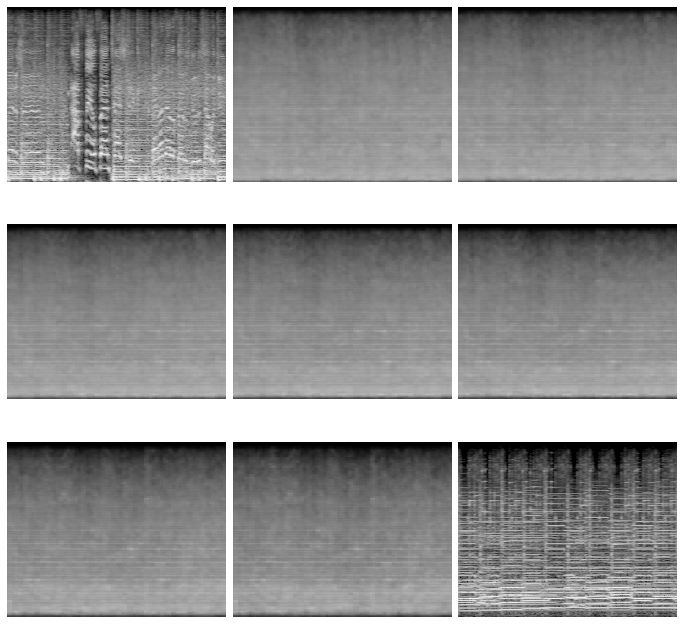

In [306]:
from time import time
import librosa

SR = 32768
N_FFT = 4096
N_MELS = 512
HOP_LENGTH = 256
DURATION = 5
A = "../data/fma/audio/000002.mp3"
B = "../data/fma/audio/000005.mp3"

interp_dir = pathlib.Path(f"interpolation/{int(time())}")
interp_dir.mkdir(exist_ok=True, parents=True)

x, _ = librosa.load(A, sr=SR, duration=DURATION)
y, _ = librosa.load(B, sr=SR, duration=DURATION)
x = librosa.feature.melspectrogram(x, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
y = librosa.feature.melspectrogram(y, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
x, y = x[0, None], y[None, :, None]
print(x.shape)
x_mean, x_logvar = model.encode(x)
y_mean, y_logvar = model.encode(y)

# Reconstruction
fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(x[0, ..., 0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.subplot(122)
x_recon = model.sample(model.reparameterize(x_mean, x_logvar))
plt.imshow(x_recon[0, ..., 0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

# Interpolation
fractions = np.linspace(0, 1, num=INTERPOLATION_POINTS)[:, None]
means = (x_mean * (1 - fractions)) + (y_mean * fractions)  # Interpolated latent vectors
logvars = (x_logvar * (1 - fractions)) + (y_logvar * fractions)  # Interpolated latent vectors
points = model.reparameterize(means, logvars)
interpolated = model.sample(points)

num_plots = math.ceil(math.sqrt(INTERPOLATION_POINTS))
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, wspace=0.03)
for i, pred in enumerate(interpolated):
    Image.fromarray(pred[:, :, 0].numpy(), mode='F').save(interp_dir.joinpath(f'{i}.tiff'))
    plt.subplot(num_plots, num_plots, i + 1)
    if i == 0:
        Image.fromarray(x[0, :, :, 0].numpy(), mode='F').save(interp_dir.joinpath(f'a.tiff'))
        plt.imshow(x[0, ..., 0], cmap='gray', vmin=0, vmax=1)
    elif i == INTERPOLATION_POINTS - 1:
        Image.fromarray(y[0, :, :, 0].numpy(), mode='F').save(interp_dir.joinpath(f'b.tiff'))
        plt.imshow(y[0, ..., 0], cmap='gray', vmin=0, vmax=1)
    else:
        plt.imshow(pred[:, :, 0], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

plt.savefig(interp_dir.joinpath('interpolation.png'), bbox_inches='tight')

### unused code

In [55]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim, num_conv=2, input_shape=(*IMAGE_DIMS, WINDOW_SIZE)):
        super().__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=input_shape),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu',
                ),
                *[tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'
                ) for i in range(num_conv)],
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(2 * latent_dim)
            ], name="Encoder"
        )

        decoder_input_shape = (
            input_shape[0] // (2 ** (num_conv + 1)),
            input_shape[1] // (2 ** (num_conv + 1)),
            64
        )

        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim, )),
                tf.keras.layers.Dense(
                    decoder_input_shape[0] * decoder_input_shape[1] * decoder_input_shape[2],
                    activation=tf.nn.relu
                ),
                tf.keras.layers.Reshape(target_shape=(decoder_input_shape[0], 
                                                      decoder_input_shape[1], decoder_input_shape[2])),
                *[tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=(2, 2),
                    padding='SAME',
                    activation='relu'
                ) for i in range(num_conv)],
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=(2, 2),
                    padding='SAME',
                    activation='relu'
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=(1, 1), padding='SAME'
                )
            ], name="Decoder"
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        inference = self.inference_net(x)
        mean, logvar = tf.split(inference, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [56]:
model = CVAE(LATENT_DIM, num_conv=NUM_CONV,)
model.inference_net.summary()
model.generative_net.summary()